<div>
<a href="http://www.music-processing.de/"><img style="float:left;" src="../data/FMP_Teaser_Cover.png" width=40% alt="FMP"></a>
<a href="https://www.audiolabs-erlangen.de"><img src="../data/Logo_AudioLabs_Long.png" width=59% style="float: right;" alt="AudioLabs"></a>
</div>

<div>
<a href="../C7/C7.html"><img src="../data/C7_nav.png" width="100"  style="float:right;" alt="C7"></a>
<h1>Common Subsequence Matching</h1> 
</div>

<br/>

<p>
Following Section 7.3.2 of <a href="http://www.music-processing.de/">[Müller, FMP, Springer 2015]</a>, we introduce in this notebook an algorithm to find possibly long similar subsequences contained in two given sequences. This algorithm is applied for <a href="../C7/C7S3_VersionIdentification.html">version identification</a>. 

</p> 

## Alignment Scenarios

At the beginning, we want to briefly reflect on various alignment scenarios and the principles behind them. The general objective of **sequence alignment** is to identify regions of similarity 
that are shared by two given sequences $X=(x_1,x_2,\ldots,x_N)$ and $Y=(y_1,y_2,\ldots,y_M)$.
At the same time, the elements of the matching regions are brought into correspondence. Generally speaking, one may distinguish between two categories of alignments: **global** alignments and **local**. In the global case, one forces the alignment to span the entire length of the two sequences. By contrast, in the local case, one tries to identify regions of similarity within 
longer sequences that are often widely divergent overall. 

* In the [FMP notebook on dynamic time warping (DTW)](../C3/C3S2_DTWbasic.html), we have encountered a first alignment technique, where the alignment was mathematically modeled by the notion of a warping path. The **boundary condition** in this definition enforced that the two given sequences $X$ and $Y$ were aligned **globally**. Furthermore, one could adjust the degree of continuity in the alignment by suitably modifying the step size condition.

* In the context of [subsequence DTW](../C7/C7S2_SubsequenceDTW.html) used for [audio matching](../C7/C7S2_AudioMatching.html), the two sequences $X$ and $Y$ were treated in a different way. While the sequence $X$ had to be aligned as a whole, only a subsequence of the sequence $Y$ was sufficient as a matching counterpart. Therefore, this scenario required a **mixed global/local alignment** approach. Technically, the idea was to relax the boundary conditions for the sequence $Y$, where a suffix and a prefix could be left out in the alignment without any cost.

In this notebook, we deal with a **local alignment** problem, where for both sequences $X$ and $Y$ only **matching subsequences** are to be identified. To compute the matching, the boundary condition for both sequences $X$ and $Y$ is dropped. Furthermore, we need a second technical modification.
In the previous two scenarios, having a global constraint at least on the side of the sequence $X$, the alignment was computed by considering a cost-minimizing path. Now, in the local scenario with no global constraints, such an approach would lead to an empty alignment. Therefore, we introduce a different optimization criterion by looking at a score-maximizing alignment based on a **score matrix** with **positive score** (relevant information) and **negative score** (irrelevant information). 

Besides the boundary conditions considered, there are other factors that crucially influence the nature of an alignment result. For example, in **partial matching**, one drops the step size condition and replaces it by a much weaker monotonicity condition. The following figure summarizes the conceptual differences between different alignment scenarios. Further notes on the alignment variants can be found at the end of this notebook.

<img src="../data/C7/FMP_C7_F23.png" width="500px" align="middle" alt="FMP_C7_F19a.png">

## Formalization of Common Subsequence Matching Problem

Our local alignment problem is motivated by the task of [version identification](../C7/C7_ContentBasedAudioRetrieval.html), where the assumption is that the query document and the database document share a similar tonal progression in certain parts, but we know neither the degree of similarity and the duration nor the locations where these concurrences occur. In this context, our matching task can be formulated as follows: given the sequences $X=(x_1,x_2,\ldots,x_N)$  and $Y=(y_1,y_2,\ldots,y_M)$ over the feature space $\mathcal{F}$, we are looking for a subsequence within $X$ and a subsequence within $Y$ such that these two subsequences are as similar as possible. Furthermore, in the comparison of these two subsequences, we want to be able to deal with temporal deformations.

As in the case of [subsequence DTW](../C7/C7S2_SubsequenceDTW.html), this task can be expressed in the form of an optimization problem, which can be solved efficiently by using dynamic programming. However, we need to assume a different viewpoint on the given problem. In [subsequence DTW](../C7/C7S2_SubsequenceDTW.html), we looked for a **cost-minimizing subsequence** of $Y$ that matched the query $X$. This optimization criterion worked since the **entire** query sequence $X$ was forced to be matched against a subsequence of $Y$. Now, when we assume that only a **subsequence** of $X$ needs to be matched against one of $Y$, there is a trivial solution: the empty subsequences. Indeed, matching two empty sequences results in an overall cost of zero, which is an optimal solution when we assume that the cost matrix $\mathbf{C}$ has no negative values. This is definitely not what we are looking for.

Intuitively speaking, we are not only looking for subsequences that can be matched with minimal cost, but also for preferably long subsequences that have a certain relevance. In other words, we need to balance two principles at the same time: 

* minimizing the overall matching cost on the one hand, and 
* maximizing the lengths of the subsequences on the other hand.

To remedy this problem, we assume a **positive** viewpoint by using a **score matrix** (or **similarity matrix**) instead of a cost matrix. Then, instead of identifying cost-minimizing subsequences, we are looking for **score-maximizing subsequences**. Further constraints for the comparison of the subsequences are imposed by introducing negative penalty values as well as suitable step size conditions. Fixing a similarity measure $s:\mathcal{F}\times\mathcal{F}\to \mathbb{R}$, we compute an $N\times M$ score matrix by setting 

\begin{equation}
  \mathbf{S}(n,m):=s(x_n,y_m)
\end{equation} 

for $n\in[1:N]$ and $m\in[1:M]$. The properties of this sore matrix can be further improved by using the same [enhancement](../C4/C4S2_SSM-PathEnhancement.html) as described for the case of self-similarity matrices. In particular, the application of [thresholding](../C4/C4S2_SSM-Thresholding.html) with respect to a threshold parameter $\tau>0$ and a penalty parameter $\delta\leq 0$ turns out to be an important step. The score matrix is constructed in such a way that the cells that may express relevant similarity relations tend to have a positive score, whereas all other cells are given a negative score. This property is crucial in view of the following procedure, which tries to find a path component that accumulates a possibly large score. Such a path mainly lies in the positive part of $\mathbf{S}$ while avoiding running through cells of negative score.

To further formalize our problem of finding a common subsequence, we need the notion of a path to account for temporal deformations when comparing two feature sequences. As in the context of [self-similarity matrices](../C4/C4S2_SSM.html) (see Section 4.2 of <a href="http://www.music-processing.de/">[Müller, FMP, Springer 2015]</a>), a **path** is defined to be a sequence 

$$
P=((n_1,m_1), \ldots,(n_L,m_L))
$$

of cells $(n_\ell,m_\ell)\in[1:N]\times[1:M]$, $\ell\in[1:L]$, satisfying 

$$
(n_{\ell+1},m_{\ell+1}) -(n_\ell,m_\ell)\in \Sigma
$$ 

for some set $\Sigma$ of admissible **step sizes**. Thus, choosing $\Sigma=\{(0,1),(1,0),(1,1)\}$, this definition is the same as the one for a [warping path](../C3/C3S2_DTWbasic.html) except for having omitted the boundary condition. The reason for this is that we do not want to globally align the sequences $X$ and $Y$, but only subsequences. We associate for a path $P$ the two **induced segments** $\pi_1(P):=[n_1:n_L]$ and $\pi_2(P):=[m_1:m_L]$. The **score** $\sigma(P)$ of $P$ is defined as 

$$
\sigma(P) := \sum_{\ell=1}^L s(n_\ell,m_\ell).
$$

With these definitions at hand, our optimization task is to find the score-maximizing path 

$$
   P^\ast := \underset{P}{\mathrm{argmax}} \,\,\sigma(P)
$$

over all possible paths (with arbitrary start and end positions). The two best matching subsequences of $X$ and $Y$ are then given by the induced segments $\pi_1(P^\ast)$ and $\pi_2(P^\ast)$, respectively.

## Optimization Algorithm using Dynamic Programming

A score-maximizing path can be computed via dynamic programming (DP) similar to the [DTW algorithm](../C3/C3S2_DTWbasic.html). To this end, we define an $N\times M$ **accumulated score matrix** $\mathbf{D}$ by

\begin{equation}
   \mathbf{D}(n,m) := \max\{\sigma(P) \mid \mbox{$P$ is path ending at $(n,m)$ }\}
\end{equation}

for $n\in[1:N]$ and $m\in[1:M]$. In other words, $\mathbf{D}(n,m)$ is the maximal possible score that can be 
accumulated by a path that starts at some arbitrary cell but ends with cell $(n,m)$. In this definition, the empty path $P=\emptyset$ is considered to be a path of score $\sigma(P)=0$. For cells $(n,m)$ with $n=1$ or $m=1$, one obtains

\begin{eqnarray}
  \mathbf{D}(1,1)&=&\max\big\{0,\mathbf{S}(1,1)\big\},\\
  \mathbf{D}(n,1)&=&\max\big\{0,\mathbf{D}(n-1,1)+\mathbf{S}(n,1)\big\} \mbox{ for } n\in [2:N],\\
  \mathbf{D}(1,m)&=&\max\big\{0,\mathbf{D}(1,m-1)+\mathbf{S}(1,m)\big\}  \mbox{ for } m\in [2:M],
\end{eqnarray}

constituting the boundary cases for our recursion. For  $n\in [2:N]$ and $m\in [2:M]$, one can compute $\mathbf{D}$ via

\begin{equation}
  \mathbf{D}(n,m)= \max\left\{
             \begin{array}{l}
             0, \\
             \mathbf{D}(n-1,m-1) + \mathbf{S}(n,m), \\ 
             \mathbf{D}(n-1,m) + \mathbf{S}(n,m), \\
             \mathbf{D}(n,m-1)+ \mathbf{S}(n,m). \end{array}\right.         
\end{equation}

Note that this recursion differs from the one used for DTW in two ways. First, instead of minimizing over costs, we now maximize over (possibly negative) scores. Even more important, the second difference is that the maximization includes a zero value. This modification makes it possible to start a path at any position without having accumulated any potentially negative score. This realizes the idea of possibly skipping the beginnings when comparing the sequences $X$ and $Y$.

Since we do not impose any boundary constraints on the considered paths, the score-maximizing path $P^\ast$ may end at any cell. Therefore, to obtain the maximal score over all possible paths, we need to look at the maximal entry of $\mathbf{D}$:

$$   \mathbf{D}^\mathrm{max}:=\sigma(P^\ast)=\max_{(n,m)\in[1:N]\times[1:M]}\mathbf{D}(n,m).
$$

In general, there may be several entries of $\mathbf{D}$ having maximal value. We start with one of these entries, say $q_1$, which defines the end position of an optimal path $P^\ast$. The full path is then obtained via **backtracking**&mdash;as we did with DTW. This time, however, the stop condition of the backtracking is different. Let $q_1,q_2,\ldots,q_\ell$ be the iteratively determined cells, then the backtracking is stopped as soon as a cell $q_\ell=(a,b)$ with $\mathbf{D}(a,b)=0$ or $q_\ell=(1,1)$ is reached. In the first case, the cell $q_\ell=(a,b)$ is omitted since it has a nonpositive score $\mathbf{S}(a,b)\leq 0$. This yields the optimal path $P^\ast=(q_{\ell-1},\ldots,q_1)$. In the second case the path starts with the cell $q_\ell=(1,1)$ if $\mathbf{S}(1,1)>0$ or with the cell $q_{\ell-1}$ if $\mathbf{S}(1,1)\leq 0$.

## Toy Example

To illustrate this procedure, we consider a toy example for two sequences $X=(x_1,\ldots,x_5)$ and $Y=(y_1,\ldots,y_6)$. Rather than specifying the sequences and the local similarity measure explicitly, we assume in this example that the similarity matrix $\mathbf{S}$ is given directly. The following figure shows $\mathbf{S}$ and the resulting accumulated score matrix $\mathbf{D}$. The matrix $\mathbf{D}$ assumes its maximal value at the cell $(3,5)$. Backtracking yields the score-maximizing path $P^\ast = ((1,3),(2,3),(2,4),(3,5))$ with $\sigma(P^\ast)=5$. The two induced segments are $\pi_1(P^\ast)=[1:3]$ and $\pi_2(P^\ast)=[3:5]$, which yield the subsequences $(x_1,x_2,x_3)$ and $(y_3,y_4,y_5)$.

<img src="../data/C7/FMP_C7_F20.png" width="500px" align="middle" alt="FMP_C7_F20.png">

## Implementation

In the next code cell, we provide a reference implementation for the DP-based optimization procedure. As an illustration, we continue with our previous toy example directly starting with the score matrix $\mathbf{S}$. In the [FMP notebook on version identification](../C7/C7S3_VersionIdentification.html), we will show how such a matrix may be constructed when starting with music recordings.

<div class="alert alert-block alert-warning">
<strong>Note:</strong> As in the <a href="../C3/C3S2_DTWbasic.html">DTW algorithm</a>, the implementation differs from the mathematical description above since Python indexing starts with the index 0. In particular, this applies to: 

  <ul>
    <li>Sequences:  <code>X = X[0], ..., X[N-1]</code> and <code>Y = Y[0], ..., Y[M-1]</code></li>
    <li>Score matrix and accumulated sore matrix: <code>S[0, 0], ..., C[N-1, M-1]</code> and <code>D[0, 0], ..., D[N-1, M-1]</code></li>
    <li>Path: <code>P = P[0], ..., P[L-1]</code></li>
  </ul>
</div>

In [1]:
import numpy as np
from numba import jit
import matplotlib.pyplot as plt
%matplotlib inline

# Example from Figure 7.20, [Müller, FMP, Springer 2015]
S = np.array([[1,  -2,  1,  1,  0, -2],
              [0,  -2,  1,  2, -2,  1],
              [0,   1, -2, -2,  1, -2],
              [-2,  1, -2,  1, -2, -2],
              [-2, -2,  1, -2,  1,  0]])


print('Score matrix S = ', S, sep='\n')

Score matrix S = 
[[ 1 -2  1  1  0 -2]
 [ 0 -2  1  2 -2  1]
 [ 0  1 -2 -2  1 -2]
 [-2  1 -2  1 -2 -2]
 [-2 -2  1 -2  1  0]]


Next, using dynamic programming, we compute the accumulated cost matrix $\mathbf{D}$, which yields the maximal accumulated score $\mathbf{D}^\mathrm{max}$.

In [2]:
@jit(nopython=True)
def compute_accumulated_score_matrix_common_subsequence(S):
    """Given the score matrix, compute the accumulated score matrix
    for common subsequence matching with step sizes {(1, 0), (0, 1), (1, 1)}

    Notebook: C7/C7S3_CommonSubsequence.ipynb

    Args:
        S (np.ndarray): Score matrix

    Returns:
        D (np.ndarray): Accumulated score matrix
    """
    N, M = S.shape
    D = np.zeros((N, M))

    D[0, 0] = max(0, S[0, 0])

    for n in range(1, N):
        D[n, 0] = max(0, D[n-1, 0] + S[n, 0])

    for m in range(1, M):
        D[0, m] = max(0, D[0, m-1] + S[0, m])

    for n in range(1, N):
        for m in range(1, M):
            D[n, m] = max(0, D[n-1, m-1] + S[n, m], D[n-1, m] + S[n, m], D[n, m-1] + S[n, m])

    return D

D = compute_accumulated_score_matrix_common_subsequence(S)
Dmax = np.max(D)
n, m = divmod(np.argmax(D), D.shape[1])
print('Accumulated score matrix D = ', D, sep='\n')
print('Maximal accumulated score Dmax = ', Dmax)
print('Maximizing cell (n,m) = (%d,%d)' % (n, m))

Accumulated score matrix D = 
[[1. 0. 1. 2. 2. 0.]
 [1. 0. 2. 4. 2. 3.]
 [1. 2. 0. 2. 5. 3.]
 [0. 3. 1. 3. 3. 3.]
 [0. 1. 4. 2. 4. 4.]]
Maximal accumulated score Dmax =  5.0
Maximizing cell (n,m) = (2,4)


Finally, we derive the optimal path $P^\ast$ using backtracking and its induced segments $\pi_1(P^\ast)$ and $\pi_2(P^\ast)$.

In [3]:
@jit(nopython=True)
def compute_optimal_path_common_subsequence(D, cellmax=True, n=0, m=0):
    """Given an accumulated score matrix, compute the score-maximizing path
    for common subsequence matching with step sizes {(1, 0), (0, 1), (1, 1)}

    Notebook: C7/C7S3_CommonSubsequence.ipynb

    Args:
        D (np.ndarray): Accumulated score matrix
        cellmax (bool): If "True", score-maximizing cell will be computed (Default value = True)
        n (int): Index (first axis) of cell for backtracking start; only used when cellmax=False (Default value = 0)
        m (int): Index (second axis) of cell for backtracking start; only used when cellmax=False (Default value = 0)

    Returns:
        P (np.ndarray): Score-maximizing path (array of index pairs)
    """
    if cellmax:
        # n, m = np.unravel_index(np.argmax(D), D.shape)  # doesn't work with jit
        n, m = divmod(np.argmax(D), D.shape[1])
    P = [(n, m)]

    while ((n, m) != (0, 0) and (D[n, m] != 0)):
        if n == 0:
            cell = (0, m-1)
        elif m == 0:
            cell = (n-1, 0)
        else:
            val = max(D[n-1, m-1], D[n-1, m], D[n, m-1])
            if val == D[n-1, m-1]:
                cell = (n-1, m-1)
            elif val == D[n-1, m]:
                cell = (n-1, m)
            else:
                cell = (n, m-1)
        P.append(cell)
        n, m = cell
    if (D[n, m] == 0):
        del P[-1]
    P.reverse()
    P = np.array(P)
    return P


@jit(nopython=True)
def get_induced_segments(P):
    """Given a path, compute the induces segments

    Notebook: C7/C7S3_CommonSubsequence.ipynb

    Args:
        P (np.ndarray): Path (list of index pairs)

    Returns:
        seg_X (np.ndarray): Induced segment of first sequence
        seg_Y (np.ndarray): Induced segment of second sequence
    """
    seg_X = np.arange(P[0, 0], P[-1, 0] + 1)
    seg_Y = np.arange(P[0, 1], P[-1, 1] + 1)
    return seg_X, seg_Y


P = compute_optimal_path_common_subsequence(D)
seg_X, seg_Y = get_induced_segments(P)

print('Optimal path P =', P, sep='\n')
print('Induced segment for X:', seg_X)
print('Induced segment for Y:', seg_Y)

Optimal path P =
[[0 2]
 [0 3]
 [1 3]
 [2 4]]
Induced segment for X: [0 1 2]
Induced segment for Y: [2 3 4]


As a sanity check, we now compute the total score of the optimal path, which agrees with $\mathbf{D}^\mathrm{max}$.

In [4]:
score_P = sum(S[n, m] for (n, m) in P)
print('Total score of optimal path:', score_P)
print('Maximal accumulated score Dmax = ', Dmax)

Total score of optimal path: 5
Maximal accumulated score Dmax =  5.0


Finally, we visualize the score matrix $\mathbf{S}$ and the accumulated score matrix $\mathbf{D}$ along with the optimal path (indicated by the red dots).

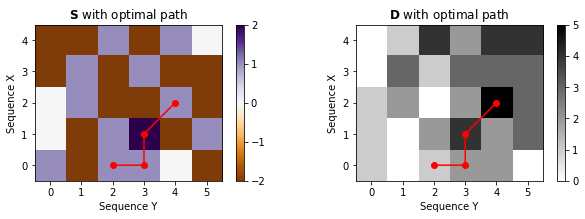

In [5]:
plt.figure(figsize=(9, 3))
plt.subplot(1, 2, 1)
plt.imshow(S, cmap='PuOr', origin='lower', aspect='equal')
plt.plot(P[:, 1], P[:, 0], marker='o', color='r')
plt.clim([np.min(S), np.max(S)])
plt.colorbar()
plt.title('$\mathbf{S}$ with optimal path')
plt.xlabel('Sequence Y')
plt.ylabel('Sequence X')

plt.subplot(1, 2, 2)
plt.imshow(D, cmap='gray_r', origin='lower', aspect='equal')
plt.plot(P[:, 1], P[:, 0], marker='o', color='r')
plt.clim([0, np.max(D)])
plt.colorbar()
plt.title('$\mathbf{D}$ with optimal path')
plt.xlabel('Sequence Y')
plt.ylabel('Sequence X')

plt.tight_layout()

## Partial Matching

As mentioned at the beginning of this notebook, one may further loosen the alignment requirements by replacing the **step size condition** by a much weaker **monotonicity condition**. This leads to an optimization problem referred to as **partial matching**. We now formalize this problem and provide an efficient algorithm based on dynamic programming. Let $X=(x_1,x_2,\ldots,x_N)$  and  $Y=(y_1,y_2,\ldots,y_M)$ be two sequences over the feature space $\mathcal{F}$. A **partial match** of length $L\in\mathbb{N}_0$ between $X$ and $Y$ is defined to be a sequence $P=((n_1,m_1), \ldots,(n_L,m_L))$ of cells $(n_\ell,m_\ell)\in[1:N]\times[1:M]$, $\ell\in[1:L]$, which is strictly monotonically increasing:

$$
n_1<n_2<\ldots < n_L \quad\mbox{and}\quad m_1< m_2< \ldots < m_L.
$$

Given a similarity measure $s:\mathcal{F}\times\mathcal{F}\to \mathbb{R}$, we define the similarity matrix $\mathbf{S}$ by $\mathbf{S}(n,m):=s(x_{n},y_{m})$. Then, the total score 
$\sigma(P)$ of a partial match $P$ is specified by 
$$
   \sigma(P) := \sum_{\ell = 1}^{L} \mathbf{S}(n_\ell,m_\ell).
$$

Without giving detailed explanations, we provide in the following table a specification of the algorithm based on dynamic programming for computing an optimal (i.e., score-maximizing) partial match:


<img src="../data/C7/FMP_C7_E10.png" width="600px" align="middle" alt="FMP_C7_E10.png">

Note that in the nested loop, the score value $\mathbf{S}(n,m)$ is only added in the case of a diagonal step size&mdash;as opposed to the [DTW algorithm](../C3/C3S2_DTWbasic.html), where the cost value $\mathbf{C}(n,m)$ is added in the case of all three step sizes. Furthermore, note that the optimal partial match yielding the accumulated score $\mathbf{D}(n,m)$ does **not** necessarily end in the cell $(n,m)$&mdash;in contrast with the [DTW algorithm](../C3/C3S2_DTWbasic.html), where the optimal warping path yielding $\mathbf{D}(n,m)$ always ends with the cell $(n,m)$.

In the next code cell, we provide a reference implementation for the partial matching procedure, which is then applied to our toy example from above. Again note the index shift in the implementation due to the Python convention, where indexing starts with the index 0.

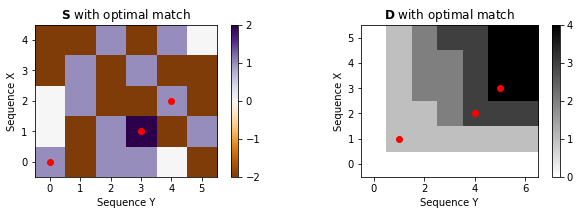

In [6]:
@jit(nopython=True)
def compute_partial_matching(S):
    """Given the score matrix, compute the accumulated score matrix
    for partial matching

    Notebook: C7/C7S3_CommonSubsequence.ipynb

    Args:
        S (np.ndarray): Score matrix

    Returns:
        D (np.ndarray): Accumulated score matrix
        P (np.ndarray): Partial match (array of index pairs)
    """
    N, M = S.shape
    D = np.zeros((N+1, M+1))
    for n in range(1, N+1):
        for m in range(1, M+1):
            D[n, m] = max(D[n, m-1], D[n-1, m], D[n-1, m-1] + S[n-1, m-1])

    P = []
    n = N
    m = M
    while (n > 0) and (m > 0):
        if D[n, m] == D[n, m-1]:
            m = m - 1
        elif D[n, m] == D[n-1, m]:
            n = n - 1
        else:
            P.append((n-1, m-1))
            n = n - 1
            m = m - 1
    P.reverse()
    P = np.array(P)
    return D, P

D, P = compute_partial_matching(S)

plt.figure(figsize=(9, 3))
plt.subplot(1, 2, 1)
plt.imshow(S, cmap='PuOr', origin='lower', aspect='equal')
plt.plot(P[:, 1], P[:, 0], marker='o', color='r', linestyle='')
plt.clim([np.min(S), np.max(S)])
plt.colorbar()
plt.title('$\mathbf{S}$ with optimal match')
plt.xlabel('Sequence Y')
plt.ylabel('Sequence X')

plt.subplot(1, 2, 2)
plt.imshow(D, cmap='gray_r', origin='lower', aspect='equal')
plt.plot(P[:, 1]+1, P[:, 0]+1, marker='o', color='r', linestyle='')
plt.clim([0, np.max(D)])
plt.colorbar()
plt.title('$\mathbf{D}$ with optimal match')
plt.xlabel('Sequence Y')
plt.ylabel('Sequence X')

plt.tight_layout()

## Further Notes

In this notebook, we have considered the problem of common subsequence matching, which can be regarded as a local variant of [DTW](../C3/C3S2_DTWbasic.html) and [subsequence DTW](../C7/C7S2_SubsequenceDTW.html). 

* The final optimal path crucially depends on the input score matrix, where one has to encode relevant information by cells with positive score and irrelevant information by cells with negative score. In the [FMP notebook on version identifiation](../C7/C7S3_VersionIdentification.html), we give an example for how to construct such a score matrix. Closely related is also the construction of such matrices in the context of [audio thumbnailing](../C4/C4S3_AudioThumbnailing.html).

* Instead of using negative score values, one finds in the literature related approaches that use other kinds of penalty terms to account for the introduction of gaps and other discontinuities. Such an instance is the famous **Smith&ndash;Waterman algorithm**, which is widely used for the identification of common molecular subsequences.

* Replacing the step size condition by the monotonicity condition, we looked at the problem of **partial matching**. In the case of sequences over a finite alphabet (rather than elements in some Euclidean space), partial matching is closely related to the **longest common subsequence** (LCS) problem whose objective is to find the longest subsequence shared by two (or more) sequences.

<div class="alert" style="background-color:#F5F5F5; border-color:#C8C8C8">
<strong>Acknowledgment:</strong> This notebook was created by <a href="https://www.audiolabs-erlangen.de/fau/professor/mueller">Meinard Müller</a>, Tim Zunner, and <a href="https://www.audiolabs-erlangen.de/fau/assistant/zalkow">Frank Zalkow</a>.
</div>  

<table style="border:none">
<tr style="border:none">
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C0/C0.html"><img src="../data/C0_nav.png" style="height:50px" alt="C0"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C1/C1.html"><img src="../data/C1_nav.png" style="height:50px" alt="C1"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C2/C2.html"><img src="../data/C2_nav.png" style="height:50px" alt="C2"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C3/C3.html"><img src="../data/C3_nav.png" style="height:50px" alt="C3"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C4/C4.html"><img src="../data/C4_nav.png" style="height:50px" alt="C4"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C5/C5.html"><img src="../data/C5_nav.png" style="height:50px" alt="C5"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C6/C6.html"><img src="../data/C6_nav.png" style="height:50px" alt="C6"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C7/C7.html"><img src="../data/C7_nav.png" style="height:50px" alt="C7"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C8/C8.html"><img src="../data/C8_nav.png" style="height:50px" alt="C8"></a></td>
</tr>
</table>